<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/docs/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

#Quantization-Aware Finetuning YoloNAS on a Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset: the [RF Soccer Players Dataset](https://universe.roboflow.com/roboflow-100/soccer-players-5fuqs) .

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from Nvidia.

## Step 0: Dataset Setup

First, follow this link will download the RF Soccer Players Dataset:
 - Follow the [dataset download page](https://universe.roboflow.com/roboflow-100/soccer-players-5fuqs/dataset/2/download).
 - Sign up or login to Roboflow.
 - Click on download, then select "COCO" as the format. Click "continue".
 - Under "Jupyter" option, you will see the code below, replace "YOUR_API_KEY" with the one given to you in the pop up box.

# Installations

In [1]:
! pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://download.pytorch.org/whl/cu113


In [2]:
! pip install git+https://github.com/Deci-AI/super-gradients.git@master

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/Deci-AI/super-gradients.git (to revision master) to /tmp/pip-req-build-bzwu7a2f
  Running command git clone --filter=blob:none --quiet https://github.com/Deci-AI/super-gradients.git /tmp/pip-req-build-bzwu7a2f
  Resolved https://github.com/Deci-AI/super-gradients.git to commit 8051e4ea25a2b66136e7bf07e5fbe8fea250470e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 45.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 42.4 MB/s eta 0:00:00
  Created wheel for super-gradients: filename=super_gradients-3.5.0+master-py3-none-any.whl size=12087652 sha256=18ca87f0c0887e52e951947295532c4c46d61831ef09a54f9ba3bf90e2ad8caf
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sy0b25k/wheels/14/7e/a5/fd93bbb17f4905bafdd79b738345dd284e3e3a1dc0705fd6f8
Successfully built super-gradients
  Attempting uninstall: super-gradients
    Found existing installation: super-gradients 3.3.1
    Uninstalling super-gradients-3.3.1:
      Successfully uninstalled super-gradients-3.3.1


In [3]:
! pip install pytorch-quantization==2.1.2 --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://pypi.ngc.nvidia.com


In [1]:


import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)


PyTorch version: 1.11.0+cu113
torchvision version: 0.12.0+cu113


In [5]:
!pip install super-gradients

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
class CrowdDetectionPPYoloECollateFN(PPYoloECollateFN):
    """
    Collate function for Yolox training with additional_batch_items that includes crowd targets
    """

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:

        if self.random_resize_sizes is not None:
            data = self.random_resize(data)

        batch = default_collate(data)
        ims, targets, crowd_targets = batch
        if ims.shape[3] == 3:
            ims = torch.moveaxis(ims, -1, 1).float()

        return ims, self._format_targets(targets), {"crowd_targets": self._format_targets(crowd_targets)}


class DetectionCollateFN:
    """
    Collate function for Yolox training
    """

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        batch = default_collate(data)
        data = [sample for sample in data if sample[0].size(0) > 0]
        for sample in data:
           print("Sample shape:", sample[0].shape)
        max_size = max(sample[0].size(0) for sample in data)
        data = [(torch.nn.functional.pad(sample[0], (0, 0, 0, max_size - sample[0].size(0))), sample[1]) for sample in data]

        ims, targets = batch[0:2]
        return ims, self._format_targets(targets)

    def _format_targets(self, targets: torch.Tensor) -> torch.Tensor:
        nlabel = (targets.sum(dim=2) > 0).sum(dim=1)  # number of label per image
        targets_merged = []
        for i in range(targets.shape[0]):
            targets_im = targets[i, : nlabel[i]]
            batch_column = targets.new_ones((targets_im.shape[0], 1)) * i
            targets_merged.append(torch.cat((batch_column, targets_im), 1))
        return torch.cat(targets_merged, 0)




NameError: name 'PPYoloECollateFN' is not defined

## Step 1: Initialize train and validation dataloaders.

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for our our regular (non QAT training).

Notice how we use SG's dataloaders.get in order to initialize the data loaders, as it comes in handy when wanting to simplify the initialization of components such as the Sampler. We also use the "min_samples" option to truncate the dataset since it is a relatively small.


In [17]:
from typing import Callable, List, Union, Tuple, Optional, Dict
from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F
        

class DetectionCollateFN:
    """
    Collate function for Yolox training
    """

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        data = [sample for sample in data if sample[0].size(0) > 0]

        if not data:
            # If there are no valid samples, return empty tensors
            return torch.zeros(0), torch.zeros((0, 5))

        max_size = max(sample[0].size(0) for sample in data)
        data = [(torch.nn.functional.pad(sample[0], (0, 0, 0, max_size - sample[0].size(0))), sample[1]) for sample in data]

        ims, targets = zip(*data)
        ims = default_collate(ims)

        # Handle varying target sizes
        max_target_size = max(target.size(0) for target in targets)
        padded_targets = [torch.nn.functional.pad(target, (0, 0, 0, max_target_size - target.size(0))) for target in targets]
        targets = torch.stack(padded_targets, dim=0)

        return ims, targets



class PPYoloECollateFN:
    """
    Collate function for PPYoloE training
    """

    def __init__(self, random_resize_sizes: Union[List[int], None] = None, random_resize_modes: Union[List[int], None] = None):
        """

        :param random_resize_sizes: (rows, cols)
        """
        self.random_resize_sizes = random_resize_sizes
        self.random_resize_modes = random_resize_modes

    def __repr__(self):
        return f"PPYoloECollateFN(random_resize_sizes={self.random_resize_sizes}, random_resize_modes={self.random_resize_modes})"

    def __str__(self):
        return self.__repr__()

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.random_resize_sizes is not None:
            data = self.random_resize(data)

        batch = default_collate(data)
        ims, targets = batch
        targets = self._format_targets(targets)
        ims = torch.moveaxis(ims, -1, 1).float()

        return ims, targets

    def random_resize(self, batch):
        target_size = random.choice(self.random_resize_sizes)
        interpolation = random.choice(self.random_resize_modes)
        batch = [self.random_resize_sample(sample, target_size, interpolation) for sample in batch]
        return batch

    def random_resize_sample(self, sample, target_size, interpolation):
        if len(sample) == 2:
            image, targets = sample  # TARGETS ARE IN LABEL_CXCYWH
            with_crowd = False
        elif len(sample == 3):
            image, targets, crowd_targets = sample
            with_crowd = True
        else:
            raise RuntimeError()

        dsize = int(target_size), int(target_size)
        scale_factors = target_size / image.shape[0], target_size / image.shape[1]

        image = cv2.resize(
            image,
            dsize=dsize,
            interpolation=interpolation,
        )

        sy, sx = scale_factors
        targets[:, 1:5] *= np.array([[sx, sy, sx, sy]], dtype=targets.dtype)
        if with_crowd:
            crowd_targets[:, 1:5] *= np.array([[sx, sy, sx, sy]], dtype=targets.dtype)
            return image, targets, crowd_targets

        return image, targets

    def _format_targets(self, targets: torch.Tensor) -> torch.Tensor:
        """

        :param targets:
        :return: Tensor of shape [B, N, 6], where 6 elements are (index, c, cx, cy, w, h)
        """
        # Same collate as in YoloX. We convert to PPYoloTargets in the loss
        nlabel = (targets.sum(dim=2) > 0).sum(dim=1)  # number of label per image
        targets_merged = []
        for i in range(targets.shape[0]):
            targets_im = targets[i, : nlabel[i]]
            batch_column = targets.new_ones((targets_im.shape[0], 1)) * i
            targets_merged.append(torch.cat((batch_column, targets_im), 1))

        return torch.cat(targets_merged, 0)



class CrowdDetectionPPYoloECollateFN(PPYoloECollateFN):
    """
    Collate function for Yolox training with additional_batch_items that includes crowd targets
    """

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:

        if self.random_resize_sizes is not None:
            data = self.random_resize(data)

        batch = default_collate(data)
        ims, targets, crowd_targets = batch
        if ims.shape[3] == 3:
            ims = torch.moveaxis(ims, -1, 1).float()

        return ims, self._format_targets(targets), {"crowd_targets": self._format_targets(crowd_targets)}

In [18]:
class CrowdDetectionCollateFN(DetectionCollateFN):
    """
    Collate function for Yolox training with additional_batch_items that includes crowd targets
    """

    def __call__(self, data) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:
        batch = default_collate(data)
        ims, targets, crowd_targets = batch[0:3]
        return ims, self._format_targets(targets), {"crowd_targets": self._format_targets(crowd_targets)}


def compute_box_area(box: torch.Tensor) -> torch.Tensor:
    """
    Compute the area of one or many boxes.
    :param box: One or many boxes, shape = (4, ?), each box in format (x1, y1, x2, y2)
    :return: Area of every box, shape = (1, ?)
    """
    # box = 4xn
    return (box[2] - box[0]) * (box[3] - box[1])


def crowd_ioa(det_box: torch.Tensor, crowd_box: torch.Tensor) -> torch.Tensor:
    """
    Return intersection-over-detection_area of boxes, used for crowd ground truths.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.

    :param det_box:     Tensor of shape [N, 4]
    :param crowd_box:   Tensor of shape [M, 4]
    :return: crowd_ioa, Tensor of shape [N, M]: the NxM matrix containing the pairwise IoA values for every element in det_box and crowd_box
    """
    det_area = compute_box_area(det_box.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(det_box[:, None, 2:], crowd_box[:, 2:]) - torch.max(det_box[:, None, :2], crowd_box[:, :2])).clamp(0).prod(2)
    return inter / det_area[:, None]  # crowd_ioa = inter / det_area


def compute_detection_matching(
    output: List[torch.Tensor],
    targets: torch.Tensor,
    height: int,
    width: int,
    iou_thresholds: torch.Tensor,
    denormalize_targets: bool,
    device: str,
    crowd_targets: Optional[torch.Tensor] = None,
    top_k: int = 100,
    return_on_cpu: bool = True,
) -> List[Tuple]:
    """
    Match predictions (NMS output) and the targets (ground truth) with respect to IoU and confidence score.
    :param output:          list (of length batch_size) of Tensors of shape (num_predictions, 6)
                            format:     (x1, y1, x2, y2, confidence, class_label) where x1,y1,x2,y2 are according to image size
    :param targets:         targets for all images of shape (total_num_targets, 6)
                            format:     (index, x, y, w, h, label) where x,y,w,h are in range [0,1]
    :param height:          dimensions of the image
    :param width:           dimensions of the image
    :param iou_thresholds:  Threshold to compute the mAP
    :param device:          Device
    :param crowd_targets:   crowd targets for all images of shape (total_num_crowd_targets, 6)
                            format:     (index, x, y, w, h, label) where x,y,w,h are in range [0,1]
    :param top_k:           Number of predictions to keep per class, ordered by confidence score
    :param denormalize_targets: If True, denormalize the targets and crowd_targets
    :param return_on_cpu:   If True, the output will be returned on "CPU", otherwise it will be returned on "device"

    :return:                list of the following tensors, for every image:
        :preds_matched:     Tensor of shape (num_img_predictions, n_iou_thresholds)
                            True when prediction (i) is matched with a target with respect to the (j)th IoU threshold
        :preds_to_ignore:   Tensor of shape (num_img_predictions, n_iou_thresholds)
                            True when prediction (i) is matched with a crowd target with respect to the (j)th IoU threshold
        :preds_scores:      Tensor of shape (num_img_predictions), confidence score for every prediction
        :preds_cls:         Tensor of shape (num_img_predictions), predicted class for every prediction
        :targets_cls:       Tensor of shape (num_img_targets), ground truth class for every target
    """
    output = map(lambda tensor: None if tensor is None else tensor.to(device), output)
    targets, iou_thresholds = targets.to(device), iou_thresholds.to(device)

    # If crowd_targets is not provided, we patch it with an empty tensor
    crowd_targets = torch.zeros(size=(0, 6), device=device) if crowd_targets is None else crowd_targets.to(device)

    batch_metrics = []
    for img_i, img_preds in enumerate(output):
        # If img_preds is None (not prediction for this image), we patch it with an empty tensor
        img_preds = img_preds if img_preds is not None else torch.zeros(size=(0, 6), device=device)
        img_targets = targets[targets[:, 0] == img_i, 1:]
        img_crowd_targets = crowd_targets[crowd_targets[:, 0] == img_i, 1:]

        img_matching_tensors = compute_img_detection_matching(
            preds=img_preds,
            targets=img_targets,
            crowd_targets=img_crowd_targets,
            denormalize_targets=denormalize_targets,
            height=height,
            width=width,
            device=device,
            iou_thresholds=iou_thresholds,
            top_k=top_k,
            return_on_cpu=return_on_cpu,
        )
        batch_metrics.append(img_matching_tensors)

    return batch_metrics


def compute_img_detection_matching(
    preds: torch.Tensor,
    targets: torch.Tensor,
    crowd_targets: torch.Tensor,
    height: int,
    width: int,
    iou_thresholds: torch.Tensor,
    device: str,
    denormalize_targets: bool,
    top_k: int = 100,
    return_on_cpu: bool = True,
) -> Tuple:
    """
    Match predictions (NMS output) and the targets (ground truth) with respect to IoU and confidence score
    for a given image.
    :param preds:           Tensor of shape (num_img_predictions, 6)
                            format:     (x1, y1, x2, y2, confidence, class_label) where x1,y1,x2,y2 are according to image size
    :param targets:         targets for this image of shape (num_img_targets, 6)
                            format:     (label, cx, cy, w, h, label) where cx,cy,w,h
    :param height:          dimensions of the image
    :param width:           dimensions of the image
    :param iou_thresholds:  Threshold to compute the mAP
    :param device:
    :param crowd_targets:   crowd targets for all images of shape (total_num_crowd_targets, 6)
                            format:     (index, x, y, w, h, label) where x,y,w,h are in range [0,1]
    :param top_k:           Number of predictions to keep per class, ordered by confidence score
    :param device:          Device
    :param denormalize_targets: If True, denormalize the targets and crowd_targets
    :param return_on_cpu:   If True, the output will be returned on "CPU", otherwise it will be returned on "device"

    :return:
        :preds_matched:     Tensor of shape (num_img_predictions, n_iou_thresholds)
                                True when prediction (i) is matched with a target with respect to the (j)th IoU threshold
        :preds_to_ignore:   Tensor of shape (num_img_predictions, n_iou_thresholds)
                                True when prediction (i) is matched with a crowd target with respect to the (j)th IoU threshold
        :preds_scores:      Tensor of shape (num_img_predictions), confidence score for every prediction
        :preds_cls:         Tensor of shape (num_img_predictions), predicted class for every prediction
        :targets_cls:       Tensor of shape (num_img_targets), ground truth class for every target
    """
    num_iou_thresholds = len(iou_thresholds)

    if preds is None or len(preds) == 0:
        if return_on_cpu:
            device = "cpu"
        preds_matched = torch.zeros((0, num_iou_thresholds), dtype=torch.bool, device=device)
        preds_to_ignore = torch.zeros((0, num_iou_thresholds), dtype=torch.bool, device=device)
        preds_scores = torch.tensor([], dtype=torch.float32, device=device)
        preds_cls = torch.tensor([], dtype=torch.float32, device=device)
        targets_cls = targets[:, 0].to(device=device)
        return preds_matched, preds_to_ignore, preds_scores, preds_cls, targets_cls

    preds_matched = torch.zeros(len(preds), num_iou_thresholds, dtype=torch.bool, device=device)
    targets_matched = torch.zeros(len(targets), num_iou_thresholds, dtype=torch.bool, device=device)
    preds_to_ignore = torch.zeros(len(preds), num_iou_thresholds, dtype=torch.bool, device=device)

    preds_cls, preds_box, preds_scores = preds[:, -1], preds[:, 0:4], preds[:, 4]
    targets_cls, targets_box = targets[:, 0], targets[:, 1:5]
    crowd_targets_cls, crowd_target_box = crowd_targets[:, 0], crowd_targets[:, 1:5]

    # Ignore all but the predictions that were top_k for their class
    preds_idx_to_use = get_top_k_idx_per_cls(preds_scores, preds_cls, top_k)
    preds_to_ignore[:, :] = True
    preds_to_ignore[preds_idx_to_use] = False

    if len(targets) > 0 or len(crowd_targets) > 0:

        # CHANGE bboxes TO FIT THE IMAGE SIZE
        change_bbox_bounds_for_image_size(preds, (height, width))

        targets_box = cxcywh2xyxy(targets_box)
        crowd_target_box = cxcywh2xyxy(crowd_target_box)

        if denormalize_targets:
            targets_box[:, [0, 2]] *= width
            targets_box[:, [1, 3]] *= height
            crowd_target_box[:, [0, 2]] *= width
            crowd_target_box[:, [1, 3]] *= height

    if len(targets) > 0:

        # shape = (n_preds x n_targets)
        iou = box_iou(preds_box[preds_idx_to_use], targets_box)

        # Fill IoU values at index (i, j) with 0 when the prediction (i) and target(j) are of different class
        # Filling with 0 is equivalent to ignore these values since with want IoU > iou_threshold > 0
        cls_mismatch = preds_cls[preds_idx_to_use].view(-1, 1) != targets_cls.view(1, -1)
        iou[cls_mismatch] = 0

        # The matching priority is first detection confidence and then IoU value.
        # The detection is already sorted by confidence in NMS, so here for each prediction we order the targets by iou.
        sorted_iou, target_sorted = iou.sort(descending=True, stable=True)

        # Only iterate over IoU values higher than min threshold to speed up the process
        for pred_selected_i, target_sorted_i in (sorted_iou > iou_thresholds[0]).nonzero(as_tuple=False):

            # pred_selected_i and target_sorted_i are relative to filters/sorting, so we extract their absolute indexes
            pred_i = preds_idx_to_use[pred_selected_i]
            target_i = target_sorted[pred_selected_i, target_sorted_i]

            # Vector[j], True when IoU(pred_i, target_i) is above the (j)th threshold
            is_iou_above_threshold = sorted_iou[pred_selected_i, target_sorted_i] > iou_thresholds

            # Vector[j], True when both pred_i and target_i are not matched yet for the (j)th threshold
            are_candidates_free = torch.logical_and(~preds_matched[pred_i, :], ~targets_matched[target_i, :])

            # Vector[j], True when (pred_i, target_i) can be matched for the (j)th threshold
            are_candidates_good = torch.logical_and(is_iou_above_threshold, are_candidates_free)

            # For every threshold (j) where target_i and pred_i can be matched together ( are_candidates_good[j]==True )
            # fill the matching placeholders with True
            targets_matched[target_i, are_candidates_good] = True
            preds_matched[pred_i, are_candidates_good] = True

            # When all the targets are matched with a prediction for every IoU Threshold, stop.
            if targets_matched.all():
                break

    # Crowd targets can be matched with many predictions.
    # Therefore, for every prediction we just need to check if it has IoA large enough with any crowd target.
    if len(crowd_targets) > 0:

        # shape = (n_preds_to_use x n_crowd_targets)
        ioa = crowd_ioa(preds_box[preds_idx_to_use], crowd_target_box)

        # Fill IoA values at index (i, j) with 0 when the prediction (i) and target(j) are of different class
        # Filling with 0 is equivalent to ignore these values since with want IoA > threshold > 0
        cls_mismatch = preds_cls[preds_idx_to_use].view(-1, 1) != crowd_targets_cls.view(1, -1)
        ioa[cls_mismatch] = 0

        # For each prediction, we keep it's highest score with any crowd target (of same class)
        # shape = (n_preds_to_use)
        best_ioa, _ = ioa.max(1)

        # If a prediction has IoA higher than threshold (with any target of same class), then there is a match
        # shape = (n_preds_to_use x iou_thresholds)
        is_matching_with_crowd = best_ioa.view(-1, 1) > iou_thresholds.view(1, -1)

        preds_to_ignore[preds_idx_to_use] = torch.logical_or(preds_to_ignore[preds_idx_to_use], is_matching_with_crowd)

    if return_on_cpu:
        preds_matched = preds_matched.to("cpu")
        preds_to_ignore = preds_to_ignore.to("cpu")
        preds_scores = preds_scores.to("cpu")
        preds_cls = preds_cls.to("cpu")
        targets_cls = targets_cls.to("cpu")

    return preds_matched, preds_to_ignore, preds_scores, preds_cls, targets_cls


def get_top_k_idx_per_cls(preds_scores: torch.Tensor, preds_cls: torch.Tensor, top_k: int):
    """Get the indexes of all the top k predictions for every class

    :param preds_scores:   The confidence scores, vector of shape (n_pred)
    :param preds_cls:      The predicted class, vector of shape (n_pred)
    :param top_k:          Number of predictions to keep per class, ordered by confidence score

    :return top_k_idx:     Indexes of the top k predictions. length <= (k * n_unique_class)
    """
    n_unique_cls = torch.max(preds_cls)
    mask = preds_cls.view(-1, 1) == torch.arange(n_unique_cls + 1, device=preds_scores.device).view(1, -1)
    preds_scores_per_cls = preds_scores.view(-1, 1) * mask

    sorted_scores_per_cls, sorting_idx = preds_scores_per_cls.sort(0, descending=True)
    idx_with_satisfying_scores = sorted_scores_per_cls[:top_k, :].nonzero(as_tuple=False)
    top_k_idx = sorting_idx[idx_with_satisfying_scores.split(1, dim=1)]
    return top_k_idx.view(-1)


def compute_detection_metrics(
    preds_matched: torch.Tensor,
    preds_to_ignore: torch.Tensor,
    preds_scores: torch.Tensor,
    preds_cls: torch.Tensor,
    targets_cls: torch.Tensor,
    device: str,
    recall_thresholds: Optional[torch.Tensor] = None,
    score_threshold: Optional[float] = 0.1,
) -> Tuple:
    """
    Compute the list of precision, recall, MaP and f1 for every recall IoU threshold and for every class.

    :param preds_matched:      Tensor of shape (num_predictions, n_iou_thresholds)
                                    True when prediction (i) is matched with a target with respect to the (j)th IoU threshold
    :param preds_to_ignore     Tensor of shape (num_predictions, n_iou_thresholds)
                                    True when prediction (i) is matched with a crowd target with respect to the (j)th IoU threshold
    :param preds_scores:       Tensor of shape (num_predictions), confidence score for every prediction
    :param preds_cls:          Tensor of shape (num_predictions), predicted class for every prediction
    :param targets_cls:        Tensor of shape (num_targets), ground truth class for every target box to be detected
    :param recall_thresholds:   Recall thresholds used to compute MaP.
    :param score_threshold:    Minimum confidence score to consider a prediction for the computation of
                                    precision, recall and f1 (not MaP)
    :param device:             Device

    :return:
        :ap, precision, recall, f1: Tensors of shape (n_class, nb_iou_thrs)
        :unique_classes:            Vector with all unique target classes
    """
    preds_matched, preds_to_ignore = preds_matched.to(device), preds_to_ignore.to(device)
    preds_scores, preds_cls, targets_cls = preds_scores.to(device), preds_cls.to(device), targets_cls.to(device)

    recall_thresholds = torch.linspace(0, 1, 101, device=device) if recall_thresholds is None else recall_thresholds.to(device)

    unique_classes = torch.unique(targets_cls)
    n_class, nb_iou_thrs = len(unique_classes), preds_matched.shape[-1]

    ap = torch.zeros((n_class, nb_iou_thrs), device=device)
    precision = torch.zeros((n_class, nb_iou_thrs), device=device)
    recall = torch.zeros((n_class, nb_iou_thrs), device=device)

    for cls_i, cls in enumerate(unique_classes):
        cls_preds_idx, cls_targets_idx = (preds_cls == cls), (targets_cls == cls)
        cls_ap, cls_precision, cls_recall = compute_detection_metrics_per_cls(
            preds_matched=preds_matched[cls_preds_idx],
            preds_to_ignore=preds_to_ignore[cls_preds_idx],
            preds_scores=preds_scores[cls_preds_idx],
            n_targets=cls_targets_idx.sum(),
            recall_thresholds=recall_thresholds,
            score_threshold=score_threshold,
            device=device,
        )
        ap[cls_i, :] = cls_ap
        precision[cls_i, :] = cls_precision
        recall[cls_i, :] = cls_recall

    f1 = 2 * precision * recall / (precision + recall + 1e-16)

    return ap, precision, recall, f1, unique_classes


def compute_detection_metrics_per_cls(
    preds_matched: torch.Tensor,
    preds_to_ignore: torch.Tensor,
    preds_scores: torch.Tensor,
    n_targets: int,
    recall_thresholds: torch.Tensor,
    score_threshold: float,
    device: str,
):
    """
    Compute the list of precision, recall and MaP of a given class for every recall IoU threshold.

        :param preds_matched:      Tensor of shape (num_predictions, n_iou_thresholds)
                                        True when prediction (i) is matched with a target
                                        with respect to the(j)th IoU threshold
        :param preds_to_ignore     Tensor of shape (num_predictions, n_iou_thresholds)
                                        True when prediction (i) is matched with a crowd target
                                        with respect to the (j)th IoU threshold
        :param preds_scores:       Tensor of shape (num_predictions), confidence score for every prediction
        :param n_targets:          Number of target boxes of this class
        :param recall_thresholds:  Tensor of shape (max_n_rec_thresh) list of recall thresholds used to compute MaP
        :param score_threshold:    Minimum confidence score to consider a prediction for the computation of
                                        precision and recall (not MaP)
        :param device:             Device

        :return ap, precision, recall:  Tensors of shape (nb_iou_thrs)
    """
    nb_iou_thrs = preds_matched.shape[-1]

    tps = preds_matched
    fps = torch.logical_and(torch.logical_not(preds_matched), torch.logical_not(preds_to_ignore))

    if len(tps) == 0:
        return torch.zeros(nb_iou_thrs, device=device), torch.zeros(nb_iou_thrs, device=device), torch.zeros(nb_iou_thrs, device=device)

    # Sort by decreasing score
    dtype = torch.uint8 if preds_scores.is_cuda and preds_scores.dtype is torch.bool else preds_scores.dtype
    sort_ind = torch.argsort(preds_scores.to(dtype), descending=True)
    tps = tps[sort_ind, :]
    fps = fps[sort_ind, :]
    preds_scores = preds_scores[sort_ind].contiguous()

    # Rolling sum over the predictions
    rolling_tps = torch.cumsum(tps, axis=0, dtype=torch.float)
    rolling_fps = torch.cumsum(fps, axis=0, dtype=torch.float)

    rolling_recalls = rolling_tps / n_targets
    rolling_precisions = rolling_tps / (rolling_tps + rolling_fps + torch.finfo(torch.float64).eps)

    # Reversed cummax to only have decreasing values
    rolling_precisions = rolling_precisions.flip(0).cummax(0).values.flip(0)

    # ==================
    # RECALL & PRECISION

    # We want the rolling precision/recall at index i so that: preds_scores[i-1] >= score_threshold > preds_scores[i]
    # Note: torch.searchsorted works on increasing sequence and preds_scores is decreasing, so we work with "-"
    lowest_score_above_threshold = torch.searchsorted(-preds_scores, -score_threshold, right=False)

    if lowest_score_above_threshold == 0:  # Here score_threshold > preds_scores[0], so no pred is above the threshold
        recall = torch.zeros(nb_iou_thrs, device=device)
        precision = torch.zeros(nb_iou_thrs, device=device)  # the precision is not really defined when no pred but we need to give it a value
    else:
        recall = rolling_recalls[lowest_score_above_threshold - 1]
        precision = rolling_precisions[lowest_score_above_threshold - 1]

    # ==================
    # AVERAGE PRECISION

    # shape = (nb_iou_thrs, n_recall_thresholds)
    recall_thresholds = recall_thresholds.view(1, -1).repeat(nb_iou_thrs, 1)

    # We want the index i so that: rolling_recalls[i-1] < recall_thresholds[k] <= rolling_recalls[i]
    # Note:  when recall_thresholds[k] > max(rolling_recalls), i = len(rolling_recalls)
    # Note2: we work with transpose (.T) to apply torch.searchsorted on first dim instead of the last one
    recall_threshold_idx = torch.searchsorted(rolling_recalls.T.contiguous(), recall_thresholds, right=False).T

    # When recall_thresholds[k] > max(rolling_recalls), rolling_precisions[i] is not defined, and we want precision = 0
    rolling_precisions = torch.cat((rolling_precisions, torch.zeros(1, nb_iou_thrs, device=device)), dim=0)

    # shape = (n_recall_thresholds, nb_iou_thrs)
    sampled_precision_points = torch.gather(input=rolling_precisions, index=recall_threshold_idx, dim=0)

    # Average over the recall_thresholds
    ap = sampled_precision_points.mean(0)

    return ap, precision, recall

In [19]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import DetectionMosaic, DetectionRandomAffine, DetectionHSV, \
    DetectionHorizontalFlip, DetectionPaddedRescale, DetectionStandardize, DetectionTargetsFormatTransform
#from super_gradients.training.utils.detection_utils import DetectionCollateFN
from super_gradients.training import dataloaders
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed


trainset = COCOFormatDetectionDataset(data_dir="soccer-players-2",
                                      images_dir="train",
                                      json_annotation_file="train/_annotations.coco.json",
                                      input_dim=(640, 640),
                                      ignore_empty_annotations=False,
                                      transforms=[
                                          DetectionMosaic(prob=1., input_dim=(640, 640)),
                                          DetectionRandomAffine(degrees=0., scales=(0.5, 1.5), shear=0.,
                                                                target_size=(640, 640),
                                                                filter_box_candidates=False, border_value=128),
                                          DetectionHSV(prob=1., hgain=5, vgain=30, sgain=30),
                                          DetectionHorizontalFlip(prob=0.5),
                                          DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
                                          DetectionStandardize(max_value=255),
                                          DetectionTargetsFormatTransform(max_targets=300, input_dim=(640, 640),
                                                                          output_format="LABEL_CXCYWH")
                                      ])


valset = COCOFormatDetectionDataset(data_dir="soccer-players-2",
                                    images_dir="valid",
                                    json_annotation_file="valid/_annotations.coco.json",
                                    input_dim=(640, 640),
                                    ignore_empty_annotations=False,
                                    transforms=[
                                        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
                                        DetectionStandardize(max_value=255),
                                        DetectionTargetsFormatTransform(max_targets=300, input_dim=(640, 640),
                                                                        output_format="LABEL_CXCYWH")
                                    ])

train_loader = dataloaders.get(dataset=trainset, dataloader_params={
    "shuffle": True,
    "batch_size": 16,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "min_samples": 512
})

valid_loader = dataloaders.get(dataset=valset, dataloader_params={
    "shuffle": False,
    "batch_size": 32,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": CrowdDetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed
})



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


[2024-01-11 14:14:56] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 114/114 [00:00<00:00, 286.50it/s]
[2024-01-11 14:14:57] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|                      | 0/33 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Indexing dataset annotations: 100%|████████████| 33/33 [00:00<00:00, 381.56it/s]
[2024-01-11 14:14:57] INFO - dataloaders.py - Using min_samples=512


#Step 2: Defining training hyperparameters

In [20]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "linear_epoch_step",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=1, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(score_thres=0.1, top_k_predictions=300, num_cls=1, normalize_targets=True,
                             post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0,
                                                                                    nms_top_k=1000, max_predictions=300,
                                                                                    nms_threshold=0.7))],

    "metric_to_watch": 'mAP@0.50'}

/home/sree/anaconda3/envs/yolonas0/lib/python3.10/site-packages/super_gradients/training/losses/ppyolo_loss.py:669: DeprecationWarning: A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs
  warnings.warn(


# Step 3: Instantiate a pre-trained YoloNAS_S and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj23aGooYv_AhUTh_0HHblrAYsQFnoECAkQAQ&url=https%3A%2F%2Fcocodataset.org%2F&usg=AOvVaw2uf7n84Wuno9qgkHK-zOGp).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [21]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.processing import ComposeProcessing

trainer = Trainer(experiment_name="yolo_nas_s_100", ckpt_root_dir="sg_checkpoints_dir/")
net = models.get(Models.YOLO_NAS_S, num_classes=1, pretrained_weights="coco")
trainer.train(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)


[2024-01-11 14:15:14] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-11 14:15:15] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-01-11 14:15:15] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-01-11 14:15:16] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240111_141516_095874`
[2024-01-11 14:15:16] INFO - sg_trainer.py - Checkpoints directory: sg_checkpoints_dir/yolo_nas_s_100/RUN_20240111_141516_095874
[2024-01-11 14:15:16] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to sg_checkpoints_dir/yolo_nas_s_100/RUN_20240111_141516_095874/console_Jan11_14_15_16.txt


/home/sree/anaconda3/envs/yolonas0/lib/python3.10/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/sree/anaconda3/envs/yolonas0/lib/python3.10/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(


TypeError: 'int' object is not callable

# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [41]:
import os
net = models.get(Models.YOLO_NAS_S, num_classes=1, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
prediction = net.predict("test.jpg", fuse_model=False)

prediction.show()

FileNotFoundError: Incorrect Checkpoint path: sg_checkpoints_dir/yolo_nas_s_100/RUN_20240109_101926_915150/ckpt_best.pth (This should be an absolute path)

# Launch quantization-aware training

**IMPORTANT: This cell requires a large amount of system RAM so in order for it to run under Colab limitations please click `Runtime`-> `restart runtime`. Note that for this cell to run a Colab Pro acount is probably still required.**

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. Alll manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. The exported PTQ model is saved under our checkpoints directory.
- Finally we perform quantization aware training with our adapted training parameters- since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [ ]:
import os
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import DetectionMosaic, DetectionRandomAffine, DetectionHSV, \
    DetectionHorizontalFlip, DetectionPaddedRescale, DetectionStandardize, DetectionTargetsFormatTransform
from super_gradients.training.utils.detection_utils import DetectionCollateFN
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed

trainer = Trainer(experiment_name="yolo_nas_s_soccer_players", ckpt_root_dir="/content/sg_checkpoints_dir/")

net = models.get(Models.YOLO_NAS_S, num_classes=1, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

train_dataset_params = COCOFormatDetectionDataset(data_dir="/content/soccer-players-2/",
                                                  images_dir="train",
                                                  json_annotation_file="train/_annotations.coco.json",
                                                  input_dim=(640, 640),
                                                  ignore_empty_annotations=False,
                                                  transforms=[
                                                      DetectionMosaic(prob=1., input_dim=(640, 640)),
                                                      DetectionRandomAffine(degrees=0., scales=(0.5, 1.5), shear=0.,
                                                                            target_size=(640, 640),
                                                                            filter_box_candidates=False,
                                                                            border_value=128),
                                                      DetectionHSV(prob=1., hgain=5, vgain=30, sgain=30),
                                                      DetectionHorizontalFlip(prob=0.5),
                                                      DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
                                                      DetectionStandardize(max_value=255),
                                                      DetectionTargetsFormatTransform(max_targets=300,
                                                                                      input_dim=(640, 640),
                                                                                      output_format="LABEL_CXCYWH")
                                                  ])

val_dataset_params = COCOFormatDetectionDataset(data_dir="/content/soccer-players-2/",
                                                images_dir="valid",
                                                json_annotation_file="valid/_annotations.coco.json",
                                                input_dim=(640, 640),
                                                ignore_empty_annotations=False,
                                                transforms=[
                                                    DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
                                                    DetectionStandardize(max_value=255),
                                                    DetectionTargetsFormatTransform(max_targets=300,
                                                                                    input_dim=(640, 640),
                                                                                    output_format="LABEL_CXCYWH")
                                                ])

train_dataloader_params = {
    "shuffle": True,
    "batch_size": 16,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "min_samples": 512
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": 32,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed
}

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "linear_epoch_step",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=1, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(score_thres=0.1, top_k_predictions=300, num_cls=1, normalize_targets=True,
                             post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                    nms_top_k=1000, max_predictions=300,
                                                                                    nms_threshold=0.7))],

    "metric_to_watch": 'mAP@0.50'}

train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**val_dataset_params)


train_loader = dataloaders.get(dataset=trainset,
                               dataloader_params=train_dataloader_params)

valid_loader = dataloaders.get(dataset=valset,
                               dataloader_params=val_dataloader_params)

trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)

# Summary

And there we have it! Our PTQ and QAT checkpoints have been exported to our checkpoints directory under
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_ptq.onnx
and
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_qat.onnx".

If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

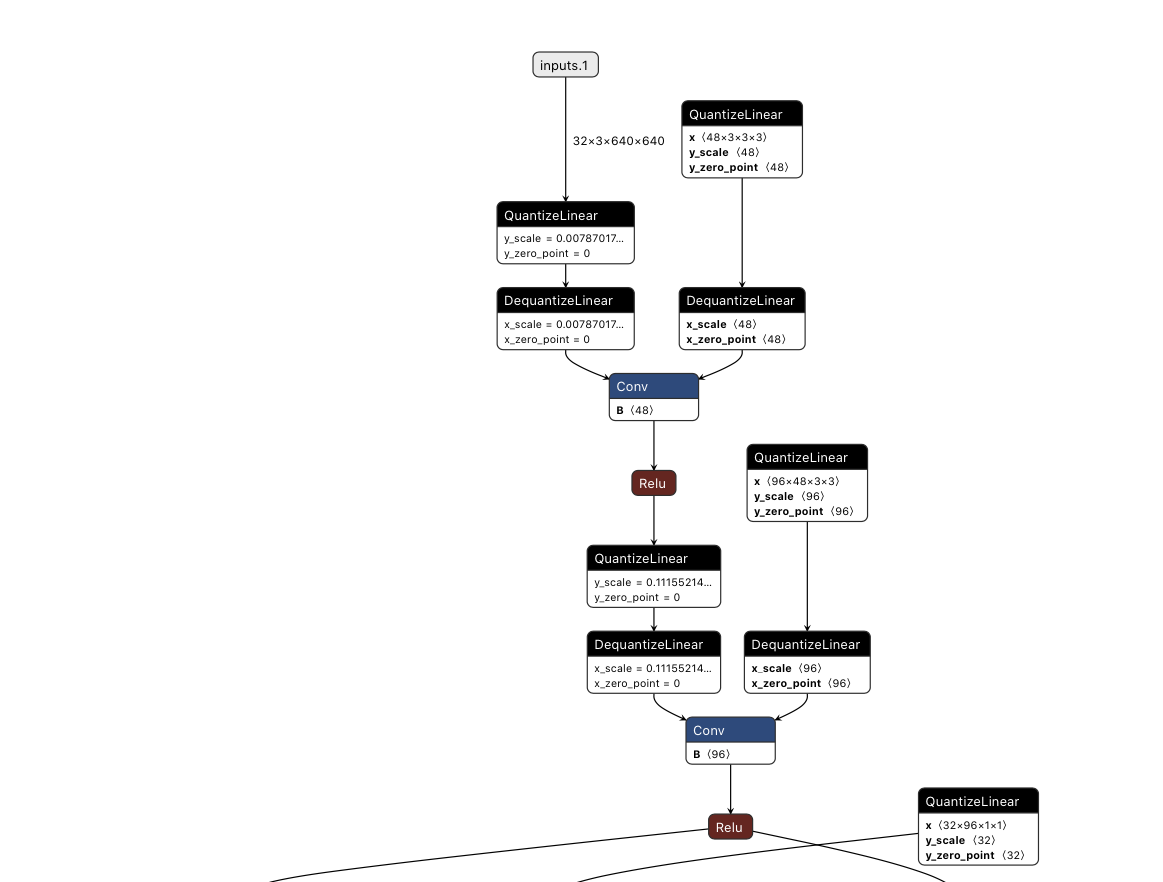

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).